In [1]:
import torch
from model import *

In [2]:
model = ChessModel()
with open("results/exp_dev/model_001.pt", "rb") as model_file:
    model.load_state_dict(torch.load(model_file))
model

ChessModel(
  (conv_blocks): ModuleList()
  (hidden_layer): Linear(in_features=448, out_features=4096, bias=True)
  (output_layer): Linear(in_features=4096, out_features=4096, bias=True)
)

In [3]:
# load the data
from train import *
positions, valid_moves = load_data()

Loading data...
Loaded data. Shape: 
positions : torch.Size([10000, 7, 8, 8])
moves     : torch.Size([10000, 4096])


In [4]:
import chess
import chess.svg
from chess_utils import action_to_move, move_to_action, board_to_tensor, tensor_to_board

In [5]:
idx = 142

In [6]:
board = positions[idx]
moves = valid_moves[idx]

In [7]:
from visualization import plot_pos_tensor, plot_move_set, plot_board_moves

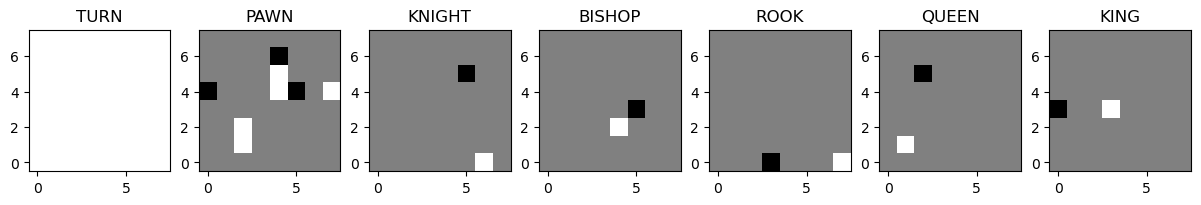

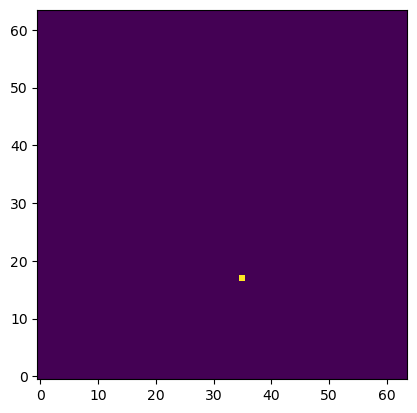

In [8]:
plot_pos_tensor(board)
plot_move_set(moves)

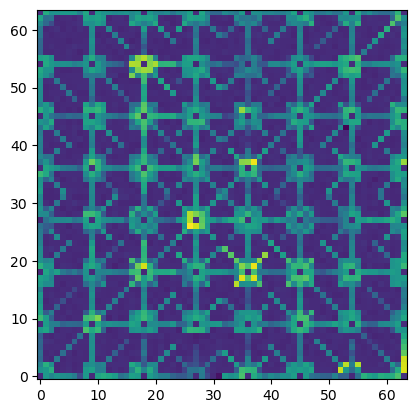

In [9]:
predicted_logits = (model(positions[[idx]]))[0].detach()
plot_move_set(predicted_logits)

In [10]:
print(predicted_logits.max())
predicted_logits

tensor(-1.8003)


tensor([-19.4864, -11.1632, -12.7434,  ..., -13.6342,  -8.9058, -19.4194])

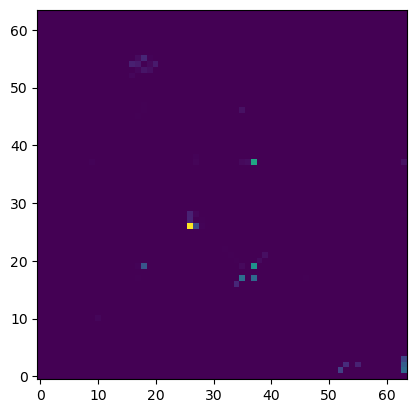

In [11]:
predicted_moves = F.softmax(model(positions[[idx]]), dim=1)[0].detach()
plot_move_set(predicted_moves)

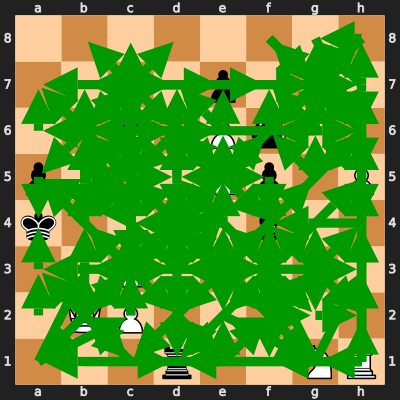

In [12]:
plot_board_moves(tensor_to_board(board), predicted_moves, k=200)

In [13]:
from evaluate import calculate_precision, calculate_recall

In [14]:
calculate_precision(predicted_moves, moves)

nan

In [15]:
predicted_positives = (predicted_moves >= 0.01)
predicted_positives, predicted_positives.sum()

(tensor([False, False, False,  ..., False, False, False]), tensor(20))

In [16]:
true_positives = predicted_positives & moves.bool()
true_positives, true_positives.sum()

(tensor([False, False, False,  ..., False, False, False]), tensor(1))

In [17]:
false_positives = predicted_positives & ~moves.bool()
false_positives, false_positives.sum()

(tensor([False, False, False,  ..., False, False, False]), tensor(19))

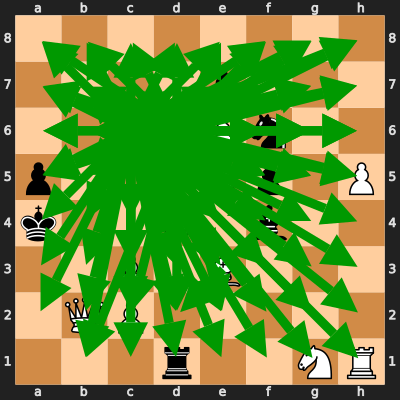

In [18]:
plot_board_moves(tensor_to_board(board), true_positives.float(), k=100)

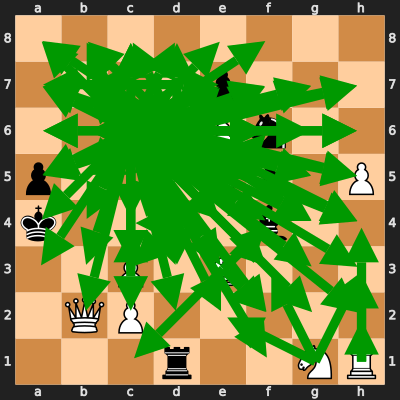

In [19]:
plot_board_moves(tensor_to_board(board), false_positives.float(), k=100)

In [20]:
false_negatives = ~predicted_positives & moves.bool()
false_negatives, false_negatives.sum()

(tensor([False, False, False,  ..., False, False, False]), tensor(0))

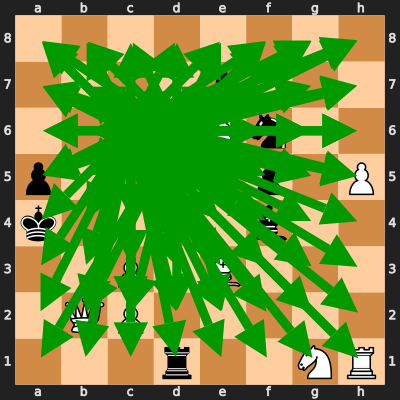

In [21]:
plot_board_moves(tensor_to_board(board), false_negatives.float(), k=100)

In [22]:
calculate_recall(predicted_positives, moves.bool())

1.0

In [23]:
all_predicted_moves = F.softmax(model(positions), dim=1)
all_predicted_moves.shape

torch.Size([10000, 4096])

In [24]:
valid_moves.shape

torch.Size([10000, 4096])

In [25]:
precisions = []
recalls = []
for i in range(0, 101):
    p = i/1000.
    precision = calculate_precision(all_predicted_moves, valid_moves, p)
    recall = calculate_recall(all_predicted_moves, valid_moves.bool(), p)
    precisions.append(precision)
    recalls.append(recall)
    print(f"{p:.2f}\t{precision*100:.2f}\t{recall*100:.2f}")

0.00	0.54	100.00
0.00	70.42	98.81
0.00	81.82	98.21
0.00	86.72	97.68
0.00	89.65	97.15
0.01	91.52	96.59
0.01	92.90	95.93
0.01	93.97	95.22
0.01	94.74	94.41
0.01	95.35	93.44
0.01	95.81	92.36
0.01	96.18	91.12
0.01	96.48	89.75
0.01	96.75	88.21
0.01	96.97	86.50
0.01	97.17	84.65
0.02	97.33	82.63
0.02	97.46	80.55
0.02	97.58	78.32
0.02	97.66	76.01
0.02	97.74	73.63
0.02	97.79	71.26
0.02	97.82	68.75
0.02	97.85	66.33
0.02	97.89	63.79
0.03	97.92	61.37
0.03	97.94	58.92
0.03	97.96	56.53
0.03	97.96	54.21
0.03	97.96	51.93
0.03	97.95	49.72
0.03	97.97	47.64
0.03	97.98	45.62
0.03	97.97	43.69
0.03	97.95	41.80
0.04	97.94	40.04
0.04	97.93	38.33
0.04	97.91	36.72
0.04	97.88	35.19
0.04	97.86	33.64
0.04	97.85	32.20
0.04	97.81	30.85
0.04	97.80	29.60
0.04	97.79	28.41
0.04	97.77	27.26
0.04	97.76	26.17
0.05	97.73	25.15
0.05	97.72	24.16
0.05	97.71	23.23
0.05	97.68	22.35
0.05	97.64	21.46
0.05	97.64	20.68
0.05	97.61	19.95
0.05	97.59	19.25
0.05	97.57	18.56
0.06	97.54	17.95
0.06	97.52	17.36
0.06	97.52	16.81
0.06	97.50	16.

In [26]:
from matplotlib import pyplot as plt

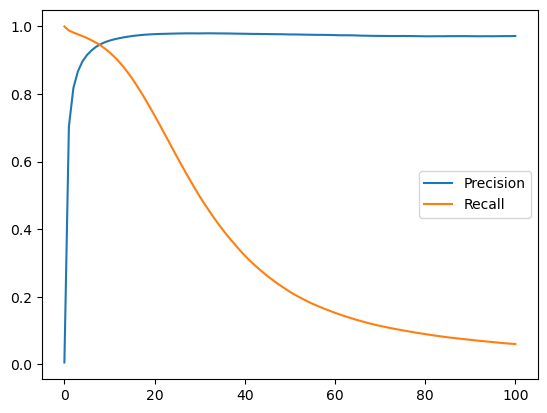

In [27]:
plt.plot(list(zip(precisions, recalls)))
plt.legend(['Precision', 'Recall'])

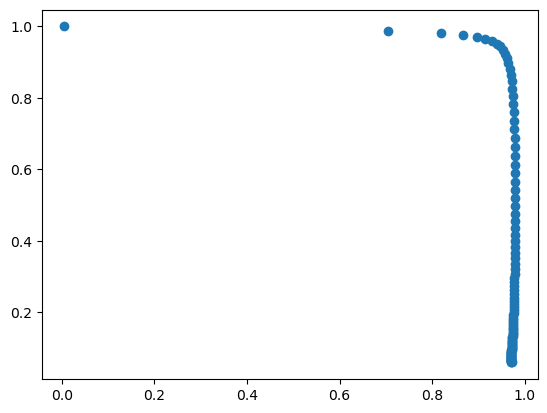

In [28]:
plt.scatter(precisions, recalls)